# Replication of Carneiro, Heckman, & Vytlacil's (2011) *Local Instrumental Variables* approach

In this notebook, I reproduce the semiparametric results from

> Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The authors analyze the returns to college for white males born between 1957 and 1963 using data from the National Longitudinal Survey of Youth 1979. The authors provide some [replication material]((https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754)) on their website but do not include geographic identifiers. Therefore, we make use of a mock data merging background characteristics and local data randomly. 


In a future update, the semiparametric estimation method will be included in the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

## 0) Imports

In [1]:
import numpy as np

from tutorial_semipar_auxiliary import plot_semipar_mte

from grmpy.estimate.estimate import fit

import warnings
warnings.filterwarnings('ignore')

## 1) The LIV Framework

The method of Local Instrumental Variables (LIV) is based on the generalized Roy model, which is characterized by the following equations:

\begin{align*}
 &\textbf{Potential Outcomes} & & \textbf{Choice}  &\\
 & Y_1 = \beta_1 X + U_{1} &  & I = Z \gamma - V &\\
 & Y_0 = \beta_0 X + U_{0} &  & D_i = \left\{
\begin{array}{ll}
1 & if \ I > 0 \\
0 & if \ I \leq 0\\
\end{array}
\right. 
&&&&\\
& \textbf{Observed Outcome} &&&\\
& Y = D Y_1 + (1-D) Y_0 &&&
\end{align*}

We work with the linear-in-the-parameters version of the generalized Roy model:

\begin{align}
E(Y|X = \overline{x}, P(Z) = p) =  \overline{x} \beta_0 + p \overline{x} (\beta_1 - \beta_0) + K(p),
\end{align}


where $K(p) = E(U_1 - U_0 | D = 1, P(Z) = p)$ is a nonlinear function of $p$ that captures heterogeneity along the unobservable resistance to treatment $u_D$. 

In addition, assume that $(X, Z)$ is independent of $\{U_1, U_0, V\}$. Then, the MTE is

1) additively separable in $X$ and $U_D$, which means that the shape of the MTE is independent of $X$, and

2) identified over the common support of $P(Z)$, unconditional on $X$. 


The common support, $P(Z)$, plays a crucial role for the identification of the MTE. 
It denotes the probability of going to university ($D=1$). Common support is defined as the intersection of the support of $P(Z)$ given $D = 1$ and the support of $P(Z)$ given $D = 0$. i.e., those evaluations of $P(Z)$ for which we obtain positive frequencies in both subsamples. We will plot it below. The larger the common support, the larger the region over which the MTE is identified.

The LIV estimator, $\Delta^{LIV}$, is derived as follows (Heckman and Vytlacil [2001](https://www.aeaweb.org/articles?id=10.1257/aer.91.2.107), [2005](https://www.jstor.org/stable/3598865?seq=1#page_scan_tab_contents)):

\begin{equation}
\begin{split}
\Delta^{LIV} (\overline{x}, u_D) &= \frac{\partial E(Y|X = \overline{x}, P(Z) = p)}{\partial p}  \bigg\rvert_{p = u_D} \\
& \\
&= \overline{x}(\beta_1 - \beta_0) + E(U_1 - U_0 | U_D = u_D) \\
&\\
& = \underbrace{\overline{x}(\beta_1 - \beta_0)}_{\substack{observable \\ component}} + \underbrace{\frac{\partial K}{\partial p} \bigg\rvert_{p = u_D}}_{\substack{k(p): \ unobservable \\ component}} = MTE(\overline{x}, u_D)
\end{split}
%\frac{[E(U_1 - U_0 | U_D \leq p] p}{\partial p}  \bigg\rvert_{p = u_D}
%E(U_1 - U_0 | U_D = u_D)
\end{equation}


Since we do not make any assumption about the functional form of the unobservables, we estimate $k(p)$ non-parametrically. In particualr, $k(p)$ is the first derivative of a locally quadratic kernel regression.

## 3) The Initialization File

For the semiparametric estimation, we need information on the following sections:

* __ESTIMATION__: Specify the dependent (wage) and indicator variable (treatment dummy) of the input data frame.
For the estimation of the propensity score $P(Z)$, we choose a probability model, here logit. Furthermore, we select 30 bins to determine the common support in the treated and untreated subsamples. For the locally quadratic regression, we follow the specification of [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) and choose a bandwidth of 0.322. The respective gridsize for the locally quadratic regression is set to 500. [Fan and Marron (1994)](https://www.tandfonline.com/doi/abs/10.1080/10618600.1994.10474629) find that a gridsize of 400 is a good default for graphical analysis. Since the data set is large (1785 observations) and the kernel regression function has a very low runtime, we increase the gridsize to 500. Setting it to the default or increasing it even more does not affect the final MTE. <br>
Note that the MTE identified by LIV consists of two components: $\overline{x}(\beta_1 - \beta_0)$ (which does not depend on $P(Z) = p$) and $k(p)$ (which does depend on $p$). The latter is estimated nonparametrically. The key "p_range" in the initialization file specifies the interval over which $k(p)$ is estimated. After the data outside the overlapping support are trimmed, the locally quadratic kernel estimator uses the remaining data to predict $k(p)$ over the entire "p_range" specified by the user. If "p_range" is larger than the common support, *grmpy* extrapolates the values for the MTE outside this region. Technically speaking, interpretations of the MTE are only valid within the common support. Here, we set "p_range" to [0.005, 0.995]. <br>
The other parameters in this section are set by default and, normally, do not need to be changed.


* __TREATED, UNTREATED, CHOICE__: In this section, the variables of the outcome equations (treated, untreated) and the college decision (choice) are specified.


* __DIST__: The distribution of the unobservables is not of relevance in the semiparametric apporach and can be ignored.

In [2]:
%%file files/tutorial_semipar.yml
---
ESTIMATION:
    file: data/aer-replication-mock.pkl
    dependent: wage
    indicator: state
    semipar: True
    show_output: True
    logit: True
    nbins: 30
    bandwidth: 0.322
    gridsize: 500
    trim_support: True
    reestimate_p: False
    rbandwidth: 0.05
    derivative: 1
    degree: 2
    ps_range: [0.005, 0.995]
TREATED:
    order:
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
UNTREATED:
    order:
    - exp
    - expsq
    - lwage5
    - lurate
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
CHOICE:
    params:
    - 1.0
    order:
    - const
    - cafqt
    - cafqtsq
    - mhgc
    - mhgcsq
    - numsibs
    - numsibssq
    - urban14
    - lavlocwage17
    - lavlocwage17sq
    - avurate
    - avuratesq
    - d57
    - d58
    - d59
    - d60
    - d61
    - d62
    - d63
    - lwage5_17numsibs
    - lwage5_17mhgc
    - lwage5_17cafqt
    - lwage5_17
    - lurate_17
    - lurate_17numsibs
    - lurate_17mhgc
    - lurate_17cafqt
    - tuit4c
    - tuit4cnumsibs
    - tuit4cmhgc
    - tuit4ccafqt
    - pub4
    - pub4numsibs
    - pub4mhgc
    - pub4cafqt
DIST:
    params:
    - 0.1
    - 0.0
    - 0.0
    - 0.1
    - 0.0
    - 1.0

Overwriting files/tutorial_semipar.yml


Note that I do not include a constant in the __TREATED, UNTREATED__ section. The reason for this is that in the semiparametric setup, $\beta_1$ and $\beta_0$ are determined by running a Double Residual Regression without an intercept:
	$$ e_Y =e_X \beta_0 \ + \ e_{X \ \times \ p} (\beta_1 - \beta_0) \ + \ \epsilon $$
    
where $e_X$, $e_{X \ \times \ p}$, and $e_Y$ are the residuals of a local linear regression of $X$, $X$ x $p$, and $Y$ on $\widehat{P}(Z)$.

We now proceed to our replication.

## 3) Estimation

Conduct the estimation based on the initialization file.

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Tue, 26 May 2020   Pseudo R-squ.:                  0.2858
Time:                        20:53:05   Log-Likelihood:                -864.74
converged:                       True   LL-Null:                       -1210.8
Covariance Type:            nonrobust   LLR p-value:                4.178e-127
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              288.3699    151.012      1.910      0.056      -7.609     584.349
cafqt               -6.4256      5.019     -1.280      0.200     -16.263       3.411
cafqtsq              0.3348 

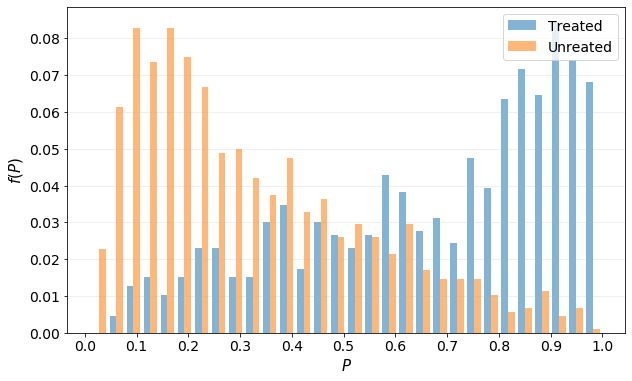

In [3]:
rslt = fit('files/tutorial_semipar.yml', semipar=True)

The rslt dictionary contains information on the estimated parameters and the final MTE. 

In [4]:
list(rslt)

['quantiles', 'mte', 'mte_x', 'mte_u', 'mte_min', 'mte_max', 'X', 'b1', 'b0']

Before plotting the MTE, let's see what else we can learn.
For instance, we can account for the variation in $X$. <br>
Note that we divide the MTE by 4 to investigate the effect of one additional year of college education.

In [5]:
np.min(rslt['mte_min']) / 4, np.max(rslt['mte_max']) / 4

(-0.5703098725415803, 0.6420576895039005)

Next we plot the MTE based on the estimation results. As shown in the figure below, the replicated MTE gets very close to the original, but its 90 percent confidence bands are wider. This is due to the use of a mock data set which merges basic and local variables randomly. The bootsrap method, which is used to estimate the confidence bands, is sensitive to the discrepancies in the data.

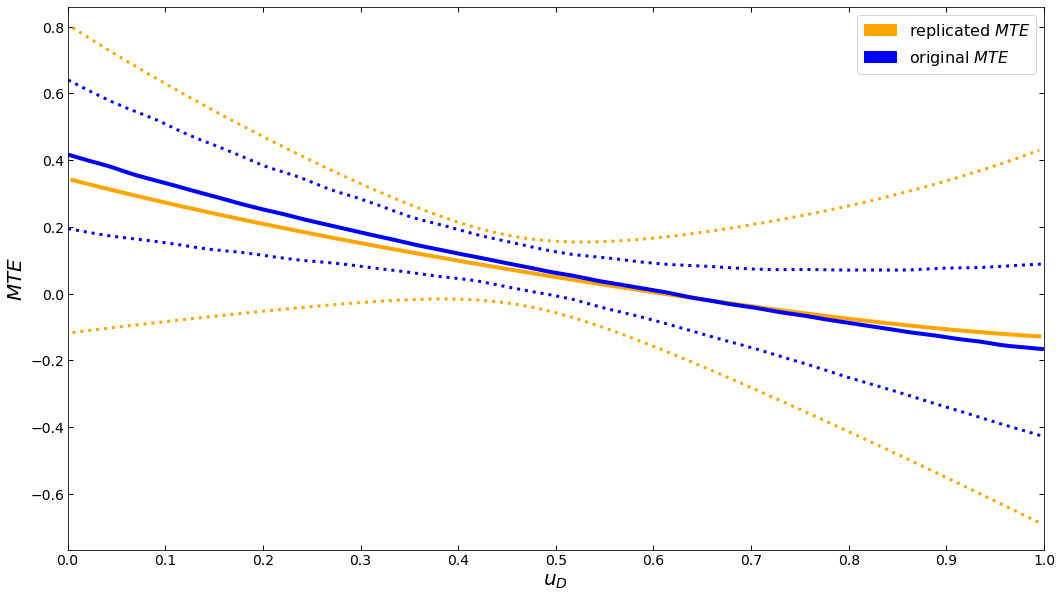

In [6]:
mte, quantiles = plot_semipar_mte(rslt, 'files/tutorial_semipar.yml', nbootstraps=250)

People with the highest returns to education (those who have low unobserved resistance $u_D$
) are more likely to go to college. Note that the returns vary considerably with $u_D$
. Low $u_D$ students have returns of up to 40% per year of college, whereas high $u_D$
 people, who would loose from attending college, have returns of approximately -18%.
    
    
The magnitude of total heterogeneity is probably even higher, as the MTE depicts the average gain of 
college attendance at the mean values of X, i.e. $\bar{x} (\beta_1 - \beta_0)$. 
Accounting for variation in $X$, we observe returns as high as 64% and as low as -57%.